In [1]:
!git clone http://github.com/KSNINJA/sim-track-data

fatal: destination path 'sim-track-data' already exists and is not an empty directory.


In [2]:
!pip3 install imgaug

In [3]:
!ls sim-track-data

driving_log.csv  IMG


In [4]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Dense, Flatten
import cv2
import pandas as pd
import ntpath
from sklearn.utils import shuffle
from imgaug import augmenters as iaa 
import random

In [5]:
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
datadir= 'sim-track-data'
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
print(data.head())

                                              center  ...     speed
0  /Users/kartiksinghal/Desktop/self-driving-proj...  ...  0.000079
1  /Users/kartiksinghal/Desktop/self-driving-proj...  ...  0.000079
2  /Users/kartiksinghal/Desktop/self-driving-proj...  ...  0.000079
3  /Users/kartiksinghal/Desktop/self-driving-proj...  ...  0.000078
4  /Users/kartiksinghal/Desktop/self-driving-proj...  ...  0.000082

[5 rows x 7 columns]


In [6]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
print(data.head())

                               center  ...     speed
0  center_2020_09_11_10_51_08_266.jpg  ...  0.000079
1  center_2020_09_11_10_51_08_367.jpg  ...  0.000079
2  center_2020_09_11_10_51_08_470.jpg  ...  0.000079
3  center_2020_09_11_10_51_08_572.jpg  ...  0.000078
4  center_2020_09_11_10_51_08_679.jpg  ...  0.000082

[5 rows x 7 columns]


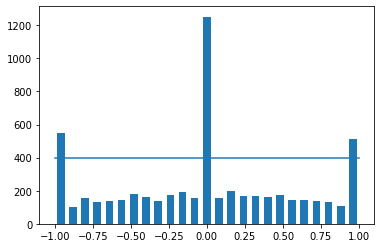

In [7]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

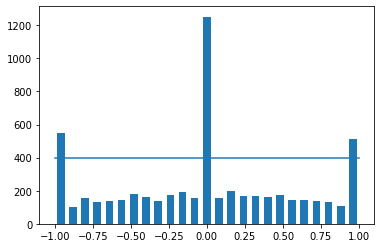

In [8]:
zero_steering_angle = data[data['steering']==0] 
zero_steering_angle = shuffle(zero_steering_angle)[:]
new_data = zero_steering_angle.append(data[data['steering']!=0]) #Remove some zero angle data, as it dominates most of training data

num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(new_data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(new_data['steering']), np.max(new_data['steering'])), (samples_per_bin, samples_per_bin))

In [9]:
X = [] #image_path of center cam
y=[] #steering angle 
for i in range(len(new_data)):
  x = new_data.iloc[i]
  X.append(os.path.join(datadir+'/IMG', x[0]))
  y.append(float(x[3]))
       

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
def preprocess_img(image):
  image = image[60:135,:, :]
  image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
  image = cv2.GaussianBlur(image, (3,3), 0)
  image = cv2.resize(image, (200, 66))
  image = image/255 #Normalisation
  return image

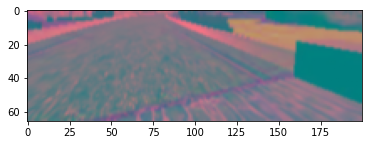

In [11]:
image = preprocess_img(mpimg.imread(X_train[5]))
plt.imshow(image)

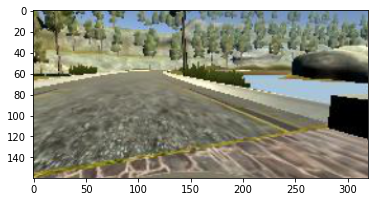

In [12]:
def zoom(image):
  zoom = iaa.Affine(scale=(1,1.3))
  image = zoom.augment_image(image)
  return image
img = mpimg.imread(X_train[5])
img = zoom(img)
plt.imshow(img)

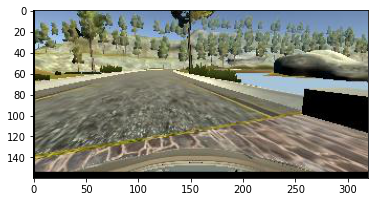

In [13]:
def pan(image):
  pan = iaa.Affine(translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image
img = mpimg.imread(X_train[5])
img = pan(img)
plt.imshow(img)

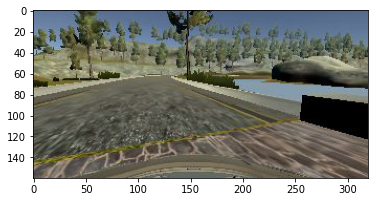

In [14]:
def img_random_brightness(image):
  new_img = iaa.Multiply((0.2, 1.2))
  new_img = new_img.augment_image(image)
  return new_img
img = mpimg.imread(X_train[5])
img = img_random_brightness(img)
plt.imshow(img)

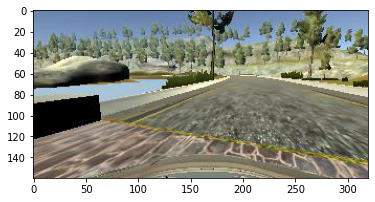

In [15]:
def img_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle *= -1
  return image, steering_angle

img = mpimg.imread(X_train[5])
img,_ = img_flip(img, y_train[5])
plt.imshow(img)

In [16]:
def random_augment(image, steering_angle):
  if(np.random.rand()<0.5):
    image = pan(image)
  if(np.random.rand()<0.5):
    image = zoom(image)
  if(np.random.rand()<0.5):
    image = img_random_brightness(image)
  if(np.random.rand()<0.5):
    image, steering_angle = img_flip(image, steering_angle)
  return image, steering_angle


In [17]:
def batch_generator(img_paths, steering_angles, batch_size, istraining):
  while(True):
    batch_img = []
    batch_steering = []
    for i in range(batch_size):
      random_index = random.randint(0, len(img_paths)-1)
      img = mpimg.imread(img_paths[random_index])
      if istraining:
        image, steering_angle = random_augment(img, steering_angles[random_index])
      else:
        image = img
        steering_angle = steering_angles[random_index]
      image = preprocess_img(image)
      batch_img.append(image)
      batch_steering.append(steering_angle)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [23]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, (5,5), input_shape=(66,200,3), strides=(2,2), activation="elu"))
  model.add(Convolution2D(36, (5,5), strides=(2,2), activation="elu"))
  model.add(Convolution2D(48, (5,5), strides=(2,2), activation="elu"))
  model.add(Convolution2D(64, (3,3), activation="elu"))
  model.add(Convolution2D(64, (3,3), activation="elu"))
  model.add(Flatten())
  model.add(Dense(100, activation="elu"))
  model.add(Dense(50, activation="elu"))
  model.add(Dense(10, activation="elu"))
  model.add(Dense(1))
  model.compile(Adam(lr=1e-4), loss="mse")
  return model

In [24]:
model = nvidia_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

In [25]:
h = model.fit(batch_generator(X_train, y_train, batch_size=100, istraining=1), steps_per_epoch=50, epochs=20, validation_data=batch_generator(X_train, y_train, batch_size=100, istraining=0), validation_steps=200,  verbose=2, shuffle='true')

Epoch 1/20
50/50 - 54s - loss: 0.3157 - val_loss: 0.2726
Epoch 2/20
50/50 - 54s - loss: 0.2825 - val_loss: 0.2378
Epoch 3/20
50/50 - 54s - loss: 0.2651 - val_loss: 0.2230
Epoch 4/20
50/50 - 54s - loss: 0.2522 - val_loss: 0.2114
Epoch 5/20
50/50 - 54s - loss: 0.2409 - val_loss: 0.1978
Epoch 6/20
50/50 - 54s - loss: 0.2293 - val_loss: 0.1966
Epoch 7/20
50/50 - 54s - loss: 0.2158 - val_loss: 0.1906
Epoch 8/20
50/50 - 54s - loss: 0.2154 - val_loss: 0.1813
Epoch 9/20
50/50 - 53s - loss: 0.1991 - val_loss: 0.1869
Epoch 10/20
50/50 - 54s - loss: 0.1965 - val_loss: 0.1667
Epoch 11/20
50/50 - 54s - loss: 0.1927 - val_loss: 0.1775
Epoch 12/20
50/50 - 53s - loss: 0.1889 - val_loss: 0.1807
Epoch 13/20
50/50 - 53s - loss: 0.1869 - val_loss: 0.1734
Epoch 14/20
50/50 - 54s - loss: 0.1917 - val_loss: 0.1681
Epoch 15/20
50/50 - 53s - loss: 0.1939 - val_loss: 0.1653
Epoch 16/20
50/50 - 53s - loss: 0.1872 - val_loss: 0.1735
Epoch 17/20
50/50 - 53s - loss: 0.1826 - val_loss: 0.1668
Epoch 18/20
50/50 - 54s

In [27]:
model.save('driveModel.h5')

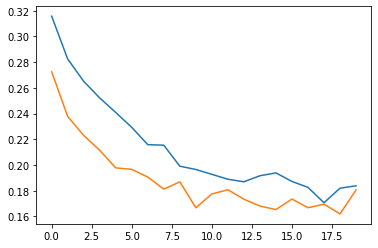

In [26]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])